In [1]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions import *

import datetime

pandas version is 1.0.1


In [2]:
# Read data and parameters from excel files

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

# Import data into df2
df2 = x2.parse('Indoor')

df2.head()

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation
0,0.0,1,0,0.0,i,"2019,3,12,13,0","2019,3,12,13,0","2019,3,12,13,0",0.750,NaN,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
1,0.7,1,0,0.0,f,"2019,3,12,13,0","2019,3,12,13,0","2019,3,19,13,0",0.753,50.0,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
2,1.0,1,1,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.144,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
3,2.0,1,2,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.153,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
4,3.0,1,3,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.159,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes


In [3]:
# Process data

# Convert Time (from a form of YYYY,M,DD,HH,mm) into hours (from begining of experiment)

T = []
for i in df2['Sample'][:]:
    T1 = df2['Timei'][df2['Sample'].values.tolist().index(i)]
    T2 = df2['Time'][df2['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
df2['T'] = T

# Make a temp DF (df2_Reduced) by filtering the original df - removing data of:
# 1. acclimation stage, 2. begining of experiments (which is constant), and 3. weeks above 3 (irrelevant here), and other irrelevant data that was excluded

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') &(df2.Comment != 'Exclude')]

df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
14,4.7,1,4,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,5.2,...,2000.0,4.0,2000.0,No,NaN,NaN,NaN,NaN,no,165
15,5.7,1,5,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,4.8,...,2000.0,4.0,2000.0,No,NaN,NaN,NaN,NaN,no,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,5.0,...,200.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,501
471,148.7,5,8,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.336,5.0,...,200.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,501


In [4]:
# list of parameters
miu = 0.03
lossess20 = 0.004
Nintmax = 4.5
Nintcrit = 2.3 
dNextoutdt = 0.015
Ks = 23
Vmax = 60
KI = 16
K0 = 2
Ka = 0.1
Smin = 0
Sopt = 28
Smax = 50
Topt = 18
Tmax = 35.9
n = 5.1

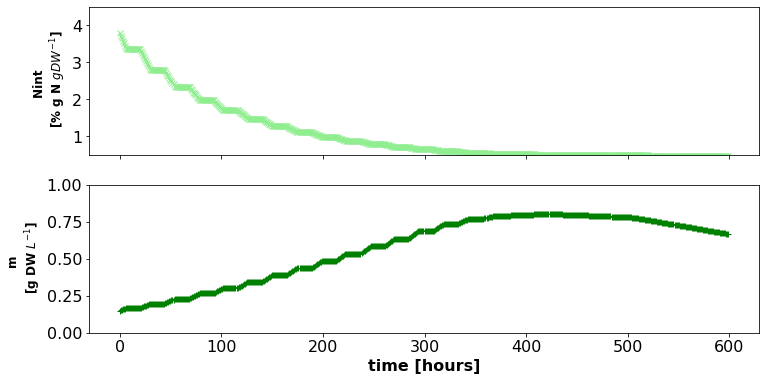

In [5]:
# Simulation of starvation experiment - add experimental data

# We first produce an array ("m/Nint_mod_all") of all model results (hours 1-504)
# Next, we organize the experimental data in three groups - calibration, validation and sporulation
# Finally, we plot simulations for each treatment and add the experimental results as dots/stars


TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Temp = 22
S = 39 # fix salinity function and S=40

NEXT, NINT, M, TT = [],[],[],[]

n_days = Duration*3


# hour = 0 is 1pm 
# in the indoor settings we have to solve for shorter periods, 
# at the beginning of the Treatment we reset Nint, Next, m
# at the beginning of each Period we set Next to the last Amplitude, 
# m0 to the end of previous solution of ode()
# 

# Let's prepare the IO(t) function that will be supplied to odeint 
# instead of a scalar. 

all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)

# 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever

# 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
# and the iniital hour as we always start at 1pm, during ontime
ontimes = np.r_[np.int(0),ontimes]

# prepare the duty cycle
I0set = np.zeros_like(all_treatment_hours)
for s,e in zip(ontimes,offtimes):
    I0set[s:e] = 80

# if you want to replace it by a "constant" I0 then replace the lines above with
# the following line and then it will also give you a constant solution you had before

# I0set = np.ones_like(all_treatment_hours)*80

Next_0 = 0
Nint_0 = 3.78
m_0 = 0.15

I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")

# Here we want to send odeint the times of the light sub-period or 
# darkness sub-period

x0 = [Next_0,Nint_0,m_0]
t = np.arange(0, 600) # can also ask for report on round hours

x = odeint(controlled_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,
                                       Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,Temp,I0),printmessg=0,hmax=.1)

NEXT.append(x[: , 0])
NINT.append(x[: , 1])
M.append(x[: , 2])
TT.append(t)

t_model = np.hstack(TT)
Next_model = np.hstack(NEXT)
Nint_model = np.hstack(NINT)
m_model = np.hstack(M)

TModAll.append(TT)


plot_result_starvation(t_model,Next_model,Nint_model,m_model)